# Exercise 8 - Image Processing in Fourier Plane
## Feb. 07, 2024

## Agenda:
- Singular Value Decomposition
- In-class math exercise: Matrix Rank from SVD
- In-class programming exercise: SVD for denoising images
- 2D Fourier Space
- In-class programming exercise: fourier transforms of images

In [1]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

## Singular Value Decomposition (SVD)

### Linear Algebra Background

For a matrix $A$ with $n$ rows and $m$ columns, we define _eigenvectors_ and _eigenvalues_ using this equation:

$
A\vec{v} = \lambda \vec{v}
$

For $\vec{v}$ to be the eigenvectors of $A$, they have to be non-zero and to satisfy this equation, which also consists of the eigenvalues $\lambda$. To find these eigenvalues and eigenvectors we solve this equation as a set, or system, of linear equations. We won't go into these details (all of you should be vaguely aware of them), but after the calculation, generally each eigenvalue will have an eigenvector.

For example, a specific matrix:

$
A = \begin{bmatrix}
2 & 1 \\
1 & 2
\end{bmatrix}
$

has an eigenvalue of $\lambda_1=3$ with an eigenvector of $\vec{v}_1=[1,1]$, and an eigenvalue of $\lambda_2=1$ with an eigenvector of $\vec{v}_2=[1,-1]$.

A theorem in linear algebra states a square matrix $A$ is diagonalizable if we can decompose it to $A=PDP^{-1}$, with $D$ being diagonal. From this follows that the columns of $P$ are its eigenvectors, and the values along the diagonal in $D$ are the eigenvalues. Of course, not all matrices are diagonalizable, since they don't always have eigenvectors that form a basis. SVD takes this concept one further step, by generalizing it to all matrices.

### Mathematical Expression of SVD

SVD breaks down a matrix into three simpler matrices, revealing many of the matrix's fundamental properties, such as rank and eigenvalues. This decomposition plays a crucial role in image compression, noise reduction, and data reduction techniques in neuroscience and biology. Let's dive into what SVD is and its components.

Singular Value Decomposition of a matrix $A$ is a method of decomposing $A$ into three special matrices:

$A = U\Sigma V^T$

Here's what each component represents:
- $A$ is any $m \times n$ real or complex matrix we want to decompose.
- $U$ is an $m \times m$ matrix, where the columns are orthogonal vectors of $A$'s column space.
- $\Sigma$ (Sigma) is an $m \times n$ diagonal matrix containing singular values of $A$ that are non-negative. These values are sorted in descending order.
- $V^T$ is the transpose of an $n \times n$ matrix, $V$, where the columns are orthogonal vectors of $A$'s row space.

### Definitions

- **Orthogonal Matrices**: A matrix is orthogonal if its columns and rows are orthogonal unit vectors (meaning they are perpendicular and have a magnitude of 1). The beauty of orthogonal matrices is that multiplying by its transpose results in the identity matrix, a key property that simplifies many mathematical operations.

- **Diagonal Matrix**: A matrix is diagonal if all entries outside the main diagonal are zero. The singular values in $\Sigma$ are placed on this diagonal.

- **Singular Values**: These are the diagonal entries of $\Sigma$. They give insight into the "importance" or "weight" of each corresponding vector in matrices $U$ and $V$. In image processing, larger singular values represent more significant features of the image, while smaller values often correspond to noise or less important details.

### Calculating SVD

We start of with the fact that the matrix $A^T A$ is symmetric, and thus its eigenvectors $x_i$ form an orthonormal basis. Assuming that their corresponding eigenvalues are $\lambda_i$, we will define $\sigma_i = \sqrt{\lambda_i}$ (these are the singular values), and another vector will be denoted as $r_i = \frac{Ax_i}{\sigma_i}$.

These quantities will construct three matrices that decompose $A$: $U$ will have $r_i$ as its columns, $V$ will have $x_i$ as its columns, and $\Sigma$ will have $\sigma_i$ as its diagonal, padded with zeros if necessary. To prove that
$$
A_{mn} = U_{mm} \Sigma_{mn} V^T_{nn} \\
$$
we'll see what is the result of the multiplication done on the right-hand side:

$$
U\Sigma = \frac{Ax_i}{\sigma_i}\sigma_i = Ax_i
$$

The next step is to multiply $U\Sigma$ by $V^T$. The columns are $Ax_i$, and the rows are of the form $x_j$. Since the eigenvectors are orthonormal, if $i \neq j$ then $x_i x_j^T = 0$, and for $i = j$ we have $x_i x_i^T = 1$, which yields

$$
U\Sigma V^T = AI = A
$$

In summary, we were able to write an arbitrary matrix $A$ using three different matrices, with $U$ and $V$ having orthonormal columns and $\Sigma$ being a diagonal matrix composed of singular values.

### Importance of SVD in Image Processing

In image processing, SVD is used for:
- **Image Compression**: By selecting only the largest singular values and discarding smaller ones, we can approximate the original image with fewer data, reducing storage and transmission requirements.
- **Noise Reduction**: Smaller singular values are often associated with noise. By eliminating them, we can clean up the image while preserving essential features.
- **Feature Extraction**: SVD helps in identifying and extracting features from images, useful in pattern recognition and machine learning applications.

## In-Class Math Exercise: Calculating Matrix Rank from SVD

To appreciate the depth of SVD, let's walk through how the rank of a matrix $A$, denoted as $\text{rank}(A)$, is equal to the number of its nonzero singular values. This involves understanding the role of $\Sigma$, the effects of orthogonal transformations ($U$ and $V$), and how these concepts interplay to preserve the rank during decomposition.

Let $A \in \mathbb{R}^{m \times n}$ have the SVD $A = U\Sigma V^T$, where:

- The ith largest singular value of $A$ is $\sigma_i$. The number of nonzero singular values of $A$ is $r$
- $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are orthogonal matrices.
- $\Sigma \in \mathbb{R}^{m \times n}$ is a diagonal matrix with singular values $\sigma_1, \sigma_2, ..., \sigma_p$ on the diagonal ($p = \min(m,n)$), where the first $r$ singular values are positive ($\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_r > 0$) and the rest are zero.

$A = U\Sigma V^T$

$\text{rank}(A) = \text{dim}(\text{Col}(A))$, where $\text{Col}(A)$ represents the column space of $A$. This corresponds to the maximum number of linearly independent columns of $A$.

$\Sigma$ diagonal implies $A$ has $r$ nonzero singular values $\Rightarrow \Sigma = \text{diag}(\sigma_1, \sigma_2, ..., \sigma_r, 0, ..., 0)$.

$\text{rank}(\Sigma) = r$ because it has $r$ nonzero entries on its diagonal, which are linearly independent.

For orthogonal matrices $U$ and $V$, $\text{rank}(U\Sigma V^T) = \text{rank}(\Sigma)$ since orthogonal transformations preserve linear independence and vector space dimensions.

Therefore, $\text{rank}(A) = \text{rank}(\Sigma) = r$

## In-Class Programmign Exercise: SVD on Images

((9, 6), (6,), (6, 6))

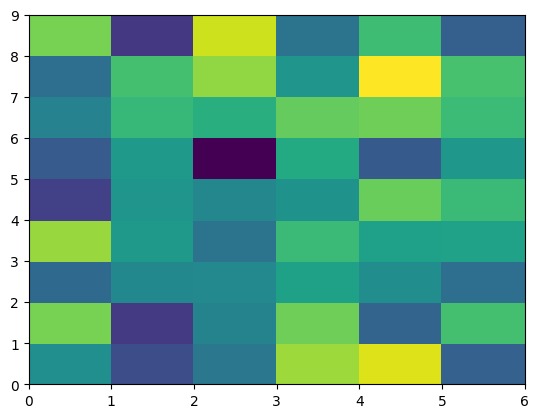

In [2]:
a = np.random.randn(9, 6)
plt.pcolor(a)
U, s, V = linalg.svd(a, full_matrices=False)  # in Matlab, svd(a)
U.shape, s.shape, V.shape

In [ ]:
S = linalg.diagsvd(s, U.shape[1], U.shape[1])
a_calc = U @ S @ V  # matrix multiplication
plt.pcolor(a_calc)

In [ ]:
# Matlab source can be found in http://andrew.gibiansky.com/blog/mathematics/cool-linear-algebra-singular-value-decomposition/
owl = plt.imread(r'ImagesExtraMaterial/owl.jpg')
plt.imshow(owl)

In [ ]:
gray_owl = color.rgb2gray(owl)

U, s, V = linalg.svd(gray_owl)
plt.semilogy(s)
plt.title('Log scale of magnitude of SVD components')

In [ ]:
plt.plot(np.cumsum(s)/ np.sum(s))
plt.title('Cumulative percent of total singular values')

In [ ]:
num_of_ranks = [3, 10, 20, 50, 100, 200]

for idx, cur_ranks in enumerate(num_of_ranks):
    cur_sigmas = s.copy()
    cur_sigmas[cur_ranks:] = 0  # Subset of the ranks
    S = linalg.diagsvd(cur_sigmas, U.shape[1], V.shape[1])
    approx_owl = U @ S @ V  # Recreate the owl
    # Plotting
    plt.subplot(3, 2, idx+1)
    plt.imshow(approx_owl, cmap='gray')
    plt.title('Rank {} owl'.format(cur_ranks))
    plt.axis('off')

plt.tight_layout()

## Fourier Transforms: From 1D to 2D

The continuous and inverse transforms:
$$ 
F(\omega)=\frac{1}{2\pi}\int_{-\infty}^{\infty}{f(t)e^{-i\omega t}}dt \\
f(t) = \int_{-\infty}^{\infty}{F(\omega) e^{i\omega t} dt}
$$

The discrete transform is very similar:

$$
F[k] = \sum_{n=0}^{N-1}{f[n] \exp{\left(-i \frac{2\pi n k}{N}\right)}} \ ; \ k \in [0, N-1] \\
f[n] = \frac{1}{N} \sum^{N-1}_{k=0}{F[k]}\exp{\left(\frac{{2\pi i k n}}{N}\right)} \ ; \ n \in [0, N-1]
$$

For example, the Fourier transform of a rectangular pulse (boxcar):

$$
f(t) = \begin{cases}
A, & -W/2 < t < W/2 \\
0, & \text{else}
\end{cases} \\
F(\omega) = \int_{- \infty}^{\infty}{f(t)e^{-2 \pi i \omega t}dt} = \int_{-W/2}^{W/2}{Ae^{-2 \pi i \omega t}dt} = \\
= AW \frac{\sin{(\pi \omega W)}}{\pi \omega W} = AW \text{sinc}(\pi \omega W)
$$

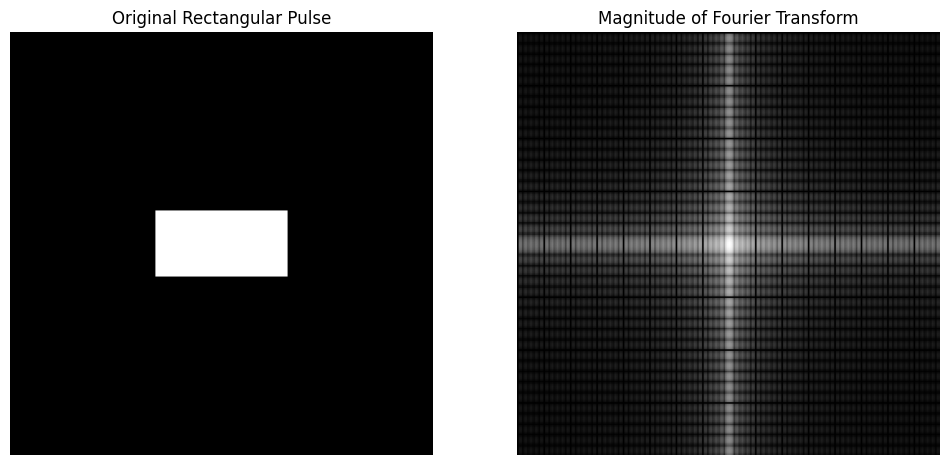

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

def create_rectangular_pulse(size, pulse_width):
    pulse = np.zeros(size)
    start_point = (size[0]//2 - pulse_width[0]//2, size[1]//2 - pulse_width[1]//2)
    pulse[start_point[0]:start_point[0]+pulse_width[0], start_point[1]:start_point[1]+pulse_width[1]] = 1
    return pulse
image_size = (256, 256)
pulse_width = (40, 80)
rect_pulse = create_rectangular_pulse(image_size, pulse_width)

ft_rect_pulse = fft2(rect_pulse)
ft_rect_pulse_shifted = fftshift(ft_rect_pulse) 

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(rect_pulse, cmap='gray')
axs[0].set_title('Original Rectangular Pulse')
axs[0].axis('off')

axs[1].imshow(np.log1p(np.abs(ft_rect_pulse_shifted)), cmap='gray')
axs[1].set_title('Magnitude of Fourier Transform')
axs[1].axis('off')

plt.show()


Why is the relation between the width in the frequency and time domain reciprocal? If we average over the _entire_ sample, only the very low frequencies will have any effect. On the contrary, if don't average at all (=average a single bin) all available frequencies will "survive" the transform.

---

Generalizing the Fourier formula to two dimensions is pretty trivial:

$$
F[k,l] = \sum_{n_1=0}^{N-1} \sum_{n_2=0}^{M-1}{f[n_1,n_2] \exp{\left( -2 \pi i \left( \frac{kn_1}{N} + \frac{ln_2}{M} \right) \right)}}
$$

That being said, we're obviously not going to prove it here. 

### Magnitude and phase

Keeping Euler's formula in mind,

$$
e^{i\theta} = \cos \theta + i \sin \theta
$$
we can write the DFT of the signal in a different way (reverting to 1D for ease of explanation):

$$
F[k] = \sum_{n=0}^{N-1}{f[n] \left( \cos(2\pi k n / N) - i\sin (2\pi k n / N) \right)}
$$
allowing us to identify the real and imaginary part of a Fourier-transformed signal more easily. Writing it in polar coordinates results in:

$$
F[k] = \left| F[k] \right| e^{-i\phi(k)}
$$
where 

$$
\left| F[k] \right| = \left[ \Re^2(k) + \Im^2(k) \right]^{1/2}
$$
is the _magnitude_ of the Fourier transform, and

$$
\phi(k) = \tan^{-1} \left[ \frac{\Im(k)}{\Re(k)} \right]
$$
is the _phase_. Note that $\Re$ denotes the real part of the signal, and $\Im$ the imaginary. Another useful definition, which we've already seen as well, is the _power spectrum_:

$$
P(k) = \left| F[k] \right|^2 = \Re^2(k) + \Im^2 (k)
$$
sometimes normalized by $N$.

For real signals, like our images, the transform is conjugate symmetric: 

$$
F[k,l] = F^*[-k, -l] \Rightarrow \left| F[k,l] \right| = \left| F[-k,-l] \right|
$$


That's why shifting the $(0,0)$ point of the transform, that indicates the DC signal, to the center of the image is so common - it creates a symmetric image in the Fourier plane. The DC component is:

$$
F[0,0] = \frac{1}{MN}\sum_{n_1=0}^{N} \sum_{n_2=0}^{M} {f[n_1, n_2]}
$$
which is just the average of the 2D function across space.


### Implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
%matplotlib inline

Text(0.5, 1.0, 'Image of 2D cosine wave')

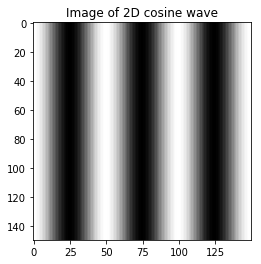

In [3]:
image_size_cos = 150  # pixels
freq = 3  # Hz

t = np.linspace(start=0, stop=image_size_cos, num=image_size_cos)
one_d_cos = np.cos(2 * np.pi * freq * t)
two_d_cos = np.ones((image_size_cos, image_size_cos))
two_d_cos *= one_d_cos  # broadcasting makes it easy
plt.imshow(two_d_cos, cmap='gray')
plt.title('Image of 2D cosine wave')

/home/hagaihargil/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Text(0.5, 1.0, 'Fourier transform of a 2D cosine signal')

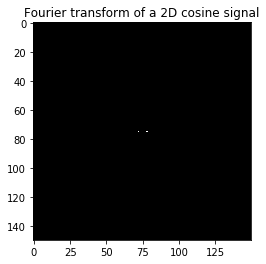

In [4]:
cosine_fourier = fftpack.fftshift(fftpack.fft2(two_d_cos))
cosine_fourier_magnitude = np.power(np.abs(cosine_fourier), 2)
plt.imshow(cosine_fourier_magnitude, cmap='gray')
plt.title('Fourier transform of a 2D cosine signal')

The farther apart the dots are, the higher frequencies they represent. The maximal frequency of an image is just a grid in which pixel $x$ is black, while pixels $x-1$ and $x+1$ are white.

---
Let's look at a different known example:

Text(0.5, 1.0, 'Rotated cosine pattern')

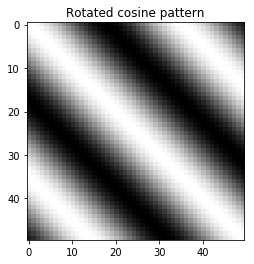

In [5]:
from skimage import transform
rotated_image_size = image_size_cos // 3
freq = 6  # Hz

t = np.linspace(start=0, stop=image_size_cos, num=image_size_cos)
one_d_cos = np.cos(2 * np.pi * freq * t)
two_d_cos = np.ones((image_size_cos, image_size_cos))
two_d_cos *= one_d_cos
rotated_cos = transform.rotate(two_d_cos, angle=45)  # In Matlab - imrotate
rotated_cos = rotated_cos[rotated_image_size:(2 * rotated_image_size),
                          rotated_image_size:(2 * rotated_image_size)]
plt.imshow(rotated_cos, cmap='gray')
plt.title('Rotated cosine pattern')

/home/hagaihargil/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Text(0.5, 1.0, 'Fourier transform of a 2D rotated cosine signal')

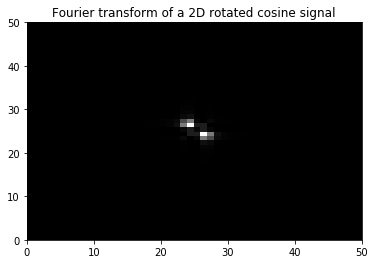

In [6]:
cosine_fourier_rotated = fftpack.fftshift(fftpack.fft2(rotated_cos))
cosine_fourier_rotated_magnitude = np.power(np.abs(cosine_fourier_rotated), 2)
plt.pcolor(cosine_fourier_rotated_magnitude, cmap='gray')
plt.title('Fourier transform of a 2D rotated cosine signal')

---
A more familiar example: A rectangle.

In [7]:
image_size = 512
rect_a = 20
rect_b = 10

image_plane = np.zeros((image_size, image_size))

# Creating a rectangle
image_plane[(image_size//2 - rect_a//2):(image_size//2 + rect_a//2),
            (image_size//2 - rect_b//2):(image_size//2 + rect_b//2)] = 1

Text(0.5, 1.0, 'Rectangle in the image plane')

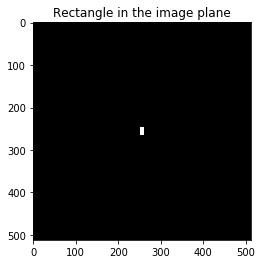

In [8]:
plt.imshow(image_plane, cmap='gray')
plt.title('Rectangle in the image plane')

Text(0.5, 1.0, 'Fourier transform of rectangle')

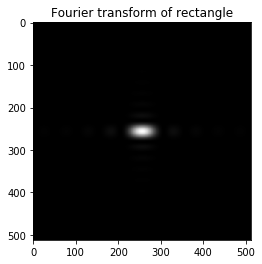

In [9]:
image_fourier = fftpack.fftshift(fftpack.fft2(image_plane))
image_fourier_magnitude = np.power(np.abs(image_fourier), 2)
image_fourier_magnitude[image_fourier_magnitude == 0] = 1e-10  # avoids division by 0
plt.imshow(image_fourier_magnitude, cmap='gray')
plt.title('Fourier transform of rectangle')

The strong DC component overshadows the rest of the figure. A simple $\log$ operation on the image can yield a better-looking result:

Text(0.5, 1.0, 'Fourier magnitude spectrum of the rectangle in log-scale')

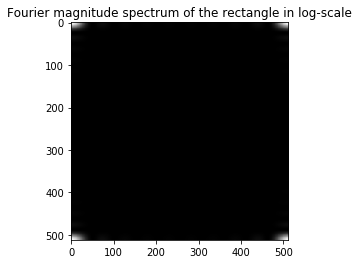

In [10]:
plt.imshow(np.log10(image_fourier_magnitude), cmap='gray')
plt.imshow(fftpack.ifftshift(image_fourier_magnitude), cmap='gray')
plt.title('Fourier magnitude spectrum of the rectangle in log-scale')

What are the properties of this plot?
* The rectangle seems to be "reversed" - happens due to the mathematical properties of the transform. It's the same phenomenon we've seen with the boxcar before.
* The data displayed is in the range [-Fs/2, Fs/2]
* This is the magnitude - and it's a $\text{sinc}$ function. 

Text(0.5, 1.0, 'The result of a Fourier transform of a rectangle in 1D')

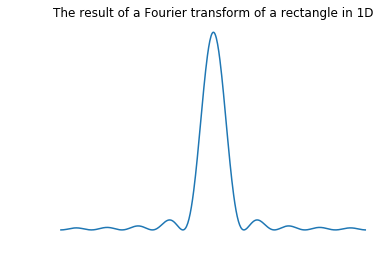

In [11]:
plt.plot(image_fourier_magnitude[image_size//2, :])
plt.axis('off')
plt.title('The result of a Fourier transform of a rectangle in 1D')

## Examples with "real" images

### Hubble deep field

In [12]:
from skimage import data
from skimage import color

Text(0.5, 1.0, 'Hubble Deep Field')

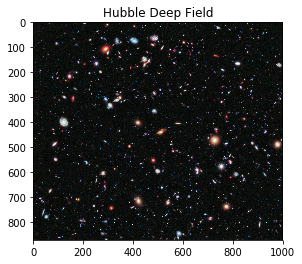

In [13]:
hubble = data.hubble_deep_field()
plt.imshow(hubble, cmap='viridis')
plt.title('Hubble Deep Field')

Text(0.5, 1.0, 'Fourier transform of many delta functions')

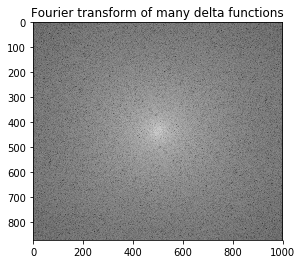

In [14]:
hubble_fourier = fftpack.fftshift(fftpack.fft2(color.rgb2gray(hubble)))
hubble_fourier_abs = np.power(np.abs(hubble_fourier), 2)
plt.imshow(np.log10(hubble_fourier_abs), cmap='gray')
plt.title('Fourier transform of many delta functions')

We see her some sort of averaging of many point-like structures, resulting in a smeared pattern of a delta function.

### Cup of coffee

Text(0.5, 1.0, 'Cup of coffee')

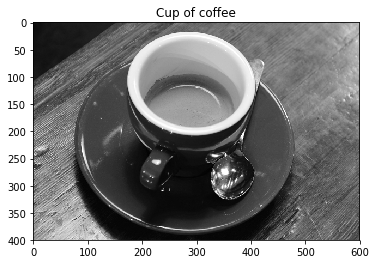

In [15]:
cof = data.coffee()
plt.imshow(color.rgb2gray(cof), cmap='gray')
plt.title('Cup of coffee')

Text(0.5, 1.0, 'Magnitude of Fourier transform of the cup of coffee')

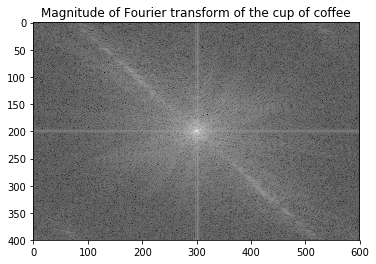

In [16]:
cof_fourier = fftpack.fftshift(fftpack.fft2(color.rgb2gray(cof)))
cof_fourier_abs = np.power(np.abs(cof_fourier), 2)
plt.imshow(np.log10(cof_fourier_abs), cmap='gray')
plt.title('Magnitude of Fourier transform of the cup of coffee')

### Phase spectrum

Let's observe the phase of the transformed image:

Text(0.5, 1.0, 'The phase spectrum of the cup of coffee')

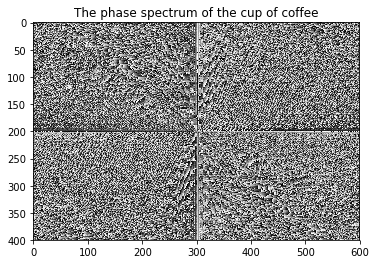

In [17]:
cof_fourier_phase = np.angle(cof_fourier)  # Same in Matlab
plt.imshow(cof_fourier_phase, cmap='gray')
plt.title('The phase spectrum of the cup of coffee')

It's obviously indiscernible. The nice thing about the frequency spectrum is that it contains more information than the magnitude spectrum for visualization. Let's switch the phase and magnitude of the cup of two images, and see what we get (think of how are we about to do it):

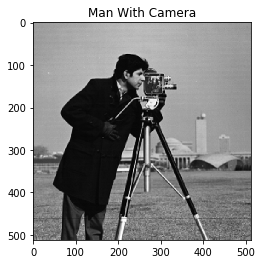

In [18]:
camera = data.camera()
plt.imshow(camera, cmap='gray')
plt.title('Man With Camera')

# Take the phase spectrum only
camera_fourier = fftpack.fft2(camera)
camera_phase = np.angle(camera_fourier)

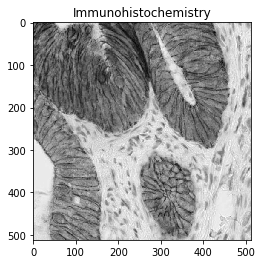

In [19]:
ihc = data.immunohistochemistry()
ihc = ihc[:,:,1]
plt.imshow(ihc, cmap='gray')
plt.title('Immunohistochemistry')

# Take the magnitude spectrum only
ihc_fourier = fftpack.fft2(ihc)
ihc_mag = np.abs(ihc_fourier)

Text(0.5, 1.0, 'The phase prevails')

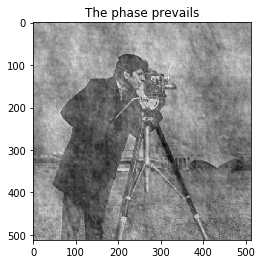

In [21]:
switched_fourier = ihc_mag * np.exp(1j * camera_phase)
# Inverse it back
switched_image = fftpack.ifft2(switched_fourier)
plt.imshow(np.real(switched_image), cmap='gray')
plt.title('The phase prevails')